In [1]:
import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)

import pandas as pd  
import numpy as np  

import tools.Sample_Tools as smpl
import tools.Pretreat_Tools as pretreat
from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)

# import ind.alpha191 as a191


import matplotlib.pyplot as plt
import seaborn as sns

from base.JuUnits import parallal_task,task_chunk_split
from base.JuUnits import excute_for_multidates



# from QUANTAXIS.QAUtil import DATABASE
# from QUANTAXIS.QAUtil import  trade_date_sse
# from QUANTAXIS.QAUtil.QADate_trade import (
#     QA_util_get_pre_trade_date,
#     QA_util_get_next_trade_date,
#     QA_util_if_tradetime
# )

# import inspect

# from sklearn import linear_model

%load_ext autoreload
%autoreload 2
%aimport ind.alpha191

In [2]:
###加载数据

ids = np.arange(1,192)
# np.random.shuffle(ids)
files = list(map(lambda x:'191_alpha'+'0'*(3- int(np.log10(x)+1))+str(x)+'_train',ids))

def load_alpha_factors(file_names):
    from tools.Cacher import (CACHE_TYPE, save_cache,load_cache_adv,load_cache)
    from base.JuUnits import excute_for_multidates
    import numpy as np
    import pandas as pd 
    
    temp = []
    for file in file_names:
        print(file)
        temp.append(load_cache(file, cache_type=CACHE_TYPE.FACTOR))
    
    return pd.concat(temp,axis=1)
        
worker=6
task = task_chunk_split(files, worker)
results = parallal_task(worker, load_alpha_factors, task)
res = pd.concat(results,axis=1)

Now in the main code. Process name is: base.JuUnits
base.JuUnits, subpid:20324  pid:25024


  0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
def filter_invalid_factor(fators_df):
    ## 缺失30%以上，且3倍方差以上，废弃
    ## 加极端判断是为了保证留下那种大窗口期的因子。
    def nan_count(x):
        return round(x.isna().sum(axis=0)/len(x),4)*100
    
    #计算缺失率
    valid_rate = excute_for_multidates(res, nan_count, level=1) 
    valid_distribute_boundary = valid_rate.mean(axis=0) + valid_rate.std(axis=0)*3
    #缺失率符合当前因子在所有标的上，符合3个标准差的
    filter_contition = valid_rate > valid_distribute_boundary 
    
    def filter_invalid(x):
        code = x.index.get_level_values(1)[0]
        distribute_condition = filter_contition.loc[code] 
        #符合3个标准差的列
        invalid_factors_name = distribute_condition[distribute_condition==True].index 
        #符合3个标准差，并且缺失30%以上的列
        thredhold_condition = valid_rate.loc[code][invalid_factors_name]>30 
        
        x[thredhold_condition.index] = np.nan 
        return x

    filtered = excute_for_multidates(fators_df, filter_invalid, level=1)
    
    return filtered

factors_filtered = filter_invalid_factor(res)

NameError: name 'a' is not defined

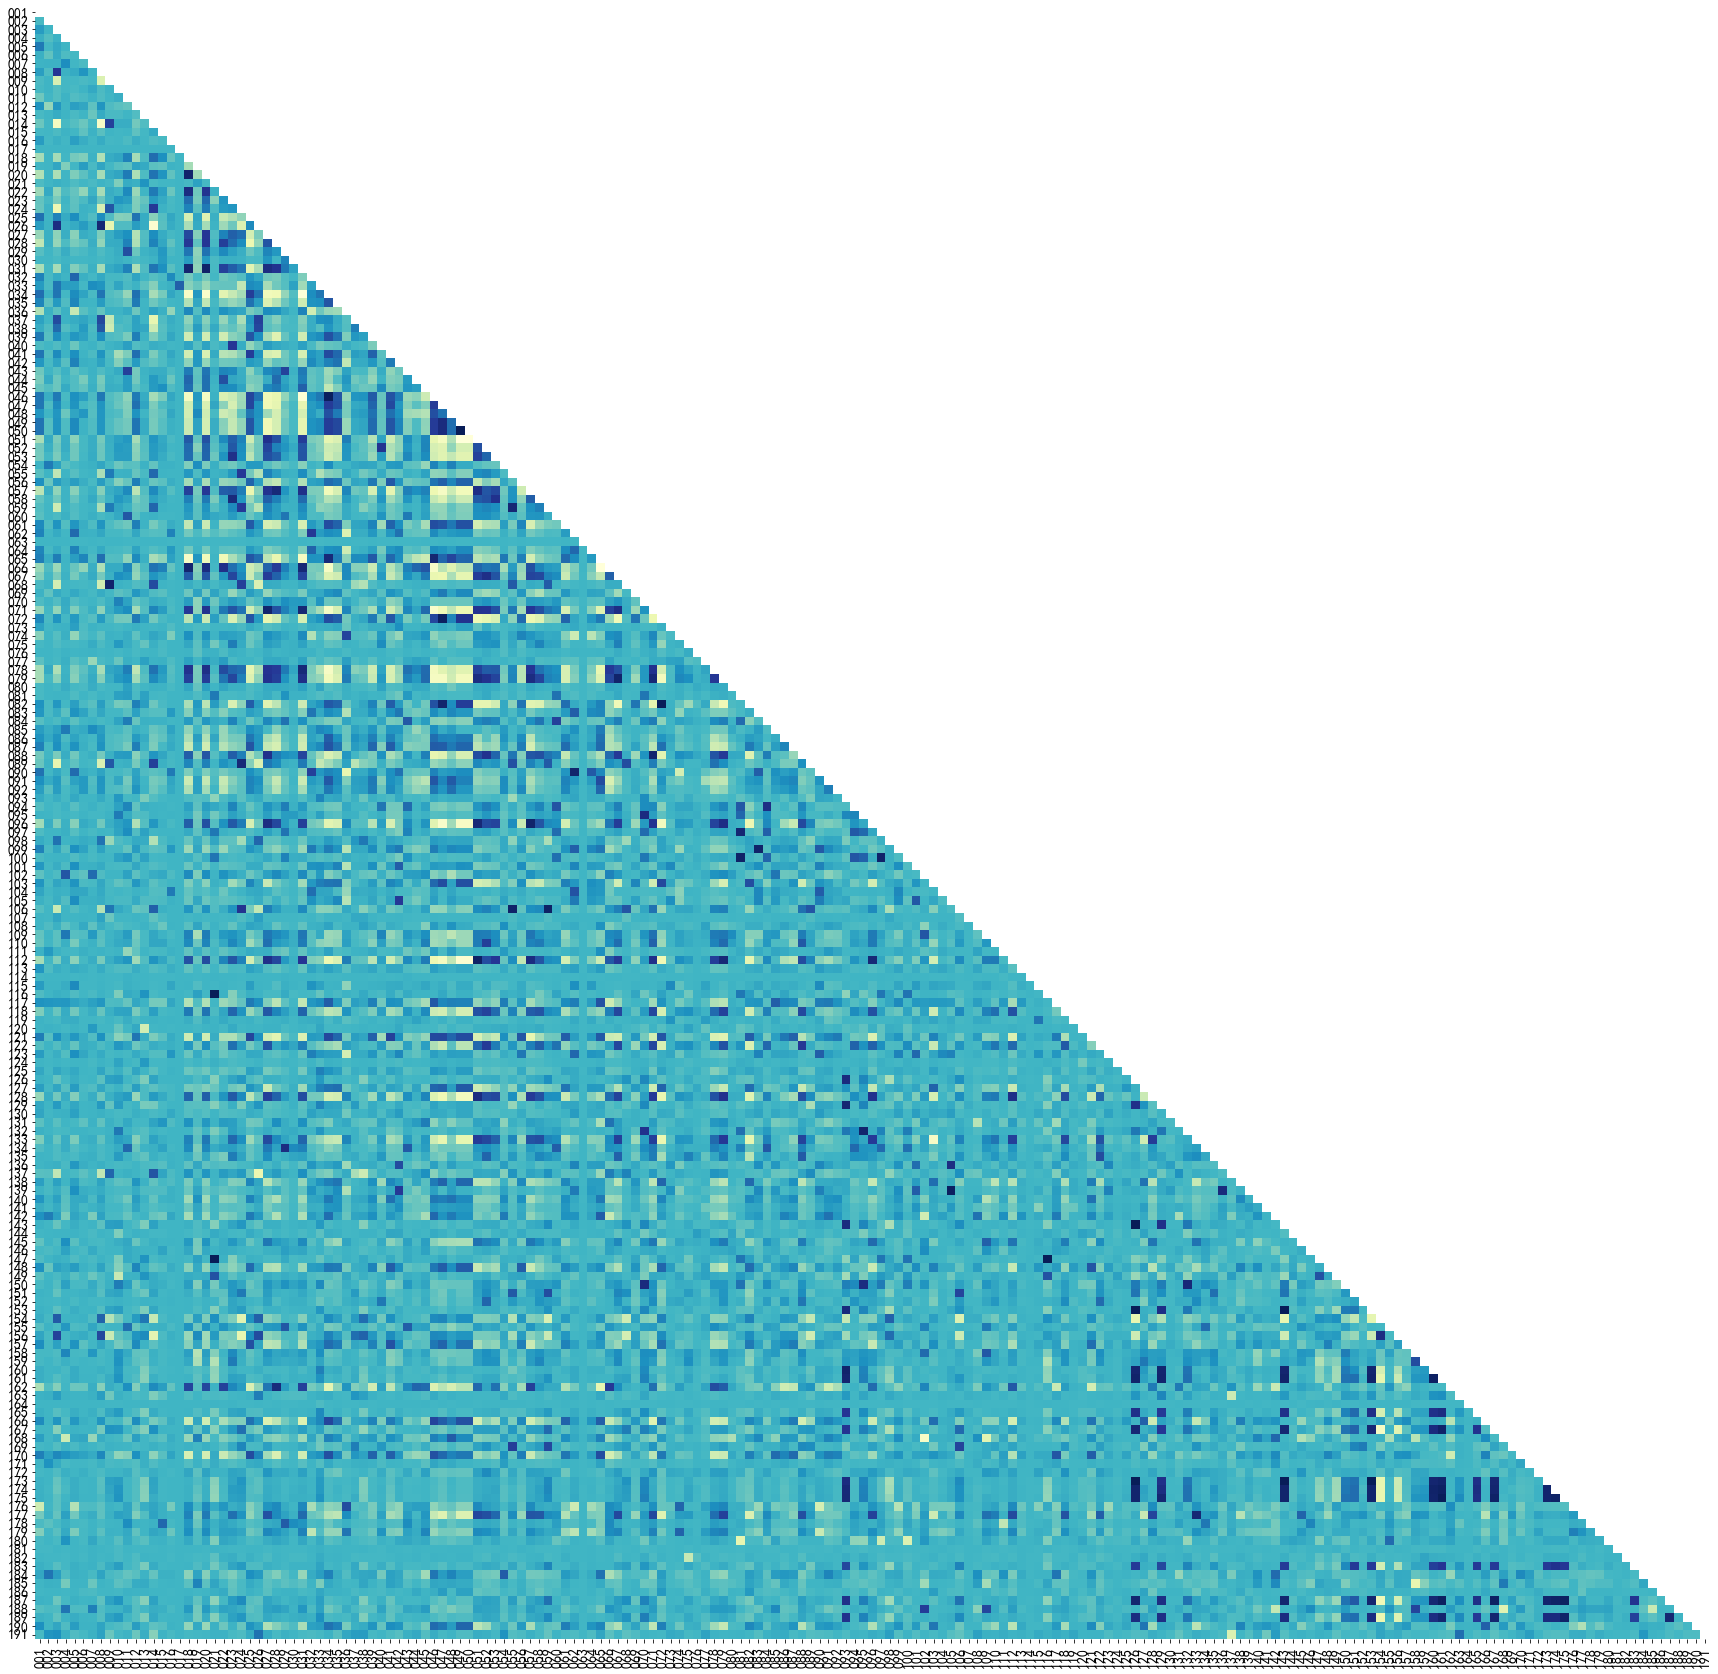

In [5]:
def filter_correlative_factor(fators_df, thredhold=.70, show_chart=False):
    #去掉相关性强的因子，相关性大于thredhold的因子（列）将被去除
    corr = fators_df.corr()
    matrix = corr.values
    #取得下三角矩阵
    matrix[np.triu_indices(matrix.shape[0])]=np.nan
    corr_triu = pd.DataFrame(matrix, columns=corr.columns, index=corr.index)

    if show_chart:
        plt.figure(figsize=(30,30))
        labels = corr.columns.str.replace('191_alpha','')
        ax = sns.heatmap(corr_triu, xticklabels=labels, yticklabels=labels, cmap="YlGnBu",cbar=False)

    # 取得符合条件的因子对后，再取“一对的左边”作为删除目标
    correlative_columns_name = corr_triu.abs().gt(thredhold).stack().loc[lambda x: x].index.get_level_values(0).unique()
    correlative_droed = fators_df.drop(columns=correlative_columns_name.to_list())
    return correlative_droed

filter_correlative_factor(factors_filtered,show_chart=True)

In [162]:
# with pd.option_context('display.max_rows', None, "display.max_columns", None): 
#     display(pd.concat([valid_rate.loc['000069',:], valid_distribute_boundary,(valid_rate.loc['000069',:]> valid_distribute_boundary)],axis=1))

# corr_triu[abs(corr_triu)>0.7]
# corr_triu.gt(.25).stack().loc[lambda df: df].index.to_list()
a = corr_triu.abs().gt(.70).stack().loc[lambda x: x].index.get_level_values(0).unique()
a


Index(['191_alpha008', '191_alpha014', '191_alpha020', '191_alpha022',
       '191_alpha024', '191_alpha026', '191_alpha027', '191_alpha028',
       '191_alpha031', '191_alpha034', '191_alpha037', '191_alpha040',
       '191_alpha046', '191_alpha047', '191_alpha049', '191_alpha050',
       '191_alpha051', '191_alpha052', '191_alpha053', '191_alpha055',
       '191_alpha057', '191_alpha058', '191_alpha059', '191_alpha062',
       '191_alpha065', '191_alpha066', '191_alpha067', '191_alpha068',
       '191_alpha071', '191_alpha072', '191_alpha078', '191_alpha079',
       '191_alpha082', '191_alpha088', '191_alpha089', '191_alpha090',
       '191_alpha094', '191_alpha095', '191_alpha096', '191_alpha097',
       '191_alpha099', '191_alpha100', '191_alpha105', '191_alpha106',
       '191_alpha112', '191_alpha116', '191_alpha121', '191_alpha122',
       '191_alpha126', '191_alpha128', '191_alpha129', '191_alpha132',
       '191_alpha133', '191_alpha134', '191_alpha136', '191_alpha137',
      